# Aperture and PSF photometry

[Photutils](https://photutils.readthedocs.io/en/stable/) is an Astropy coordinated package that provides tools for detecting and performing photometry of astronomical sources.


<section class="objectives panel panel-warning">
<div class="panel-heading">
<h2><span class="fa fa-certificate"></span> Objectives</h2>
</div>


<div class="panel-body">

<ul>
<li>Estimate and subtract backgrounds in images</li>
<li>Detect sources</li>
<li>Do aperture photometry</li>
<li>Construct a PSF</li>
<li>Do PSF photometry</li>
</ul>

</div>

</section>


## Documentation

This notebook only shows a subset of the functionality in photutils. For more information about the features presented below as well as other available features, you can read the
[photutils documentation](https://photutils.readthedocs.io/en/stable/).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))

## Background estimation and subtraction

Given a calibrated image, your first step (depending on the data) might be to subtract the background. We start off by loading one of the example datasets from photutils:

In [2]:
from photutils.datasets import load_star_image
star_image = load_star_image()

star_image

The ``star_image`` object is an HDU, so we need to access the data array when plotting it:

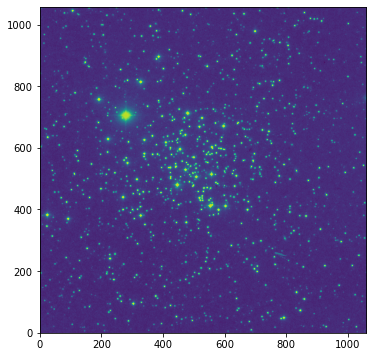

In [3]:
plt.imshow(star_image.data)

We can now make a histogram to check if the image has a significant background:

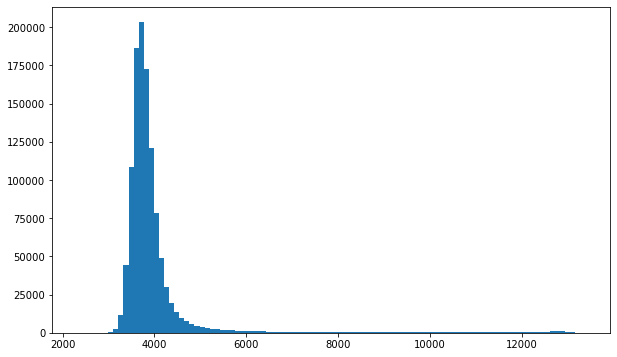

In [4]:
_ = plt.hist(star_image.data.ravel(), bins=100)

It looks like there is a background! There are many different ways of correcting for this, and one of the simplest ways would be for example to sigma clip the image and use the median of the remaining pixel values. But in some cases a more sophisticated approach is needed, so we can try and estimate the background assuming that it may be spatially varying:

In [5]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

In [6]:
sigma_clip = SigmaClip(sigma=3)
bkg_estimator = MedianBackground()

In [7]:
bkg = Background2D(star_image.data, (256, 256), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

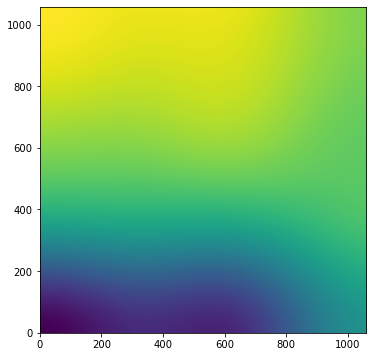

In [8]:
plt.imshow(bkg.background)

In [11]:
star_image_nobkg = star_image.data - bkg.background

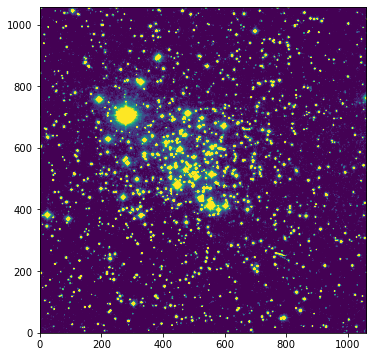

In [12]:
plt.imshow(star_image_nobkg, vmin=100, vmax=2000)

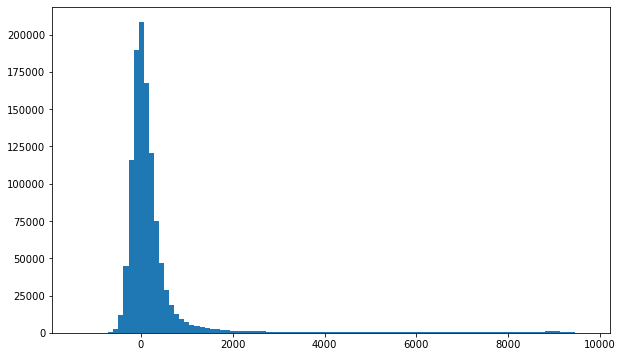

In [13]:
_ = plt.hist(star_image_nobkg.ravel(), bins=100)

## Source detection

Photutils includes several algorithms for detecting sources, including for example an implementation of the [DAOFIND](https://iraf.net/irafhelp.php?val=daofind) algorithm. First, we will need an estimate of the background noise, which we can get with sigma clipping:

In [14]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(star_image_nobkg, sigma=3)
mean, median, std

(54.51324435562827, 27.58803259355227, 233.2196500733754)

We next run the source detection:

In [16]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=5, threshold=10*std)
sources = daofind(star_image_nobkg)

The result is an astropy Table:

In [17]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,1026.783106933841,3.706429637361298,0.9267923262261807,0.14557095328380723,0.08264941248186375,49,0.0,4519.360050857209,2.234940590577084,-0.8731649579009092
2,144.23637283206799,6.364969505645846,0.8682285189319131,0.08240853048266424,0.040787507302629096,49,0.0,6875.369379461893,3.5313892017815136,-1.369863961757673
3,608.5484893616816,5.5952510991673075,0.7013330819442748,0.2600657600608783,0.006430257463397139,49,0.0,6449.574016638953,3.8980870537901935,-1.4771288343620015
4,208.67387764481904,6.864331013250369,0.7021283913151783,-0.08588645447643227,0.010198587171101014,49,0.0,7866.2387828287065,4.776755894195293,-1.6978326204196352
5,992.8711834063463,6.575519924446885,0.9817757450073543,0.08401775595850138,0.18463319730006936,49,0.0,5017.436486906998,2.383905617147848,-0.9432226423901952
6,351.65872487901765,8.521413225353895,0.6880796785051749,-0.1660835234620294,0.012953023818993662,49,0.0,6944.595422904062,4.331343821989125,-1.591556648464509
7,683.9219795910311,9.824795897002867,0.3124767828377658,0.004686995374964258,-0.04644364071167703,49,0.0,9315.75425820971,6.9401434942746185,-2.1034211250302914
8,138.02694688242593,17.55654397146486,0.8771223938504824,-0.025883811320023476,-0.09522662402543505,49,0.0,5423.427183361742,2.690111196856446,-1.0744255802876717
9,760.6556049156804,18.28523456076882,0.5882660740627209,-0.09604400434087826,-0.043700675918679356,49,0.0,8806.718843161483,5.963663602701289,-1.9387828446607491


In [22]:
subset = star_image_nobkg.copy()
subset[subset<10*std] = 0

(200.0, 600.0)

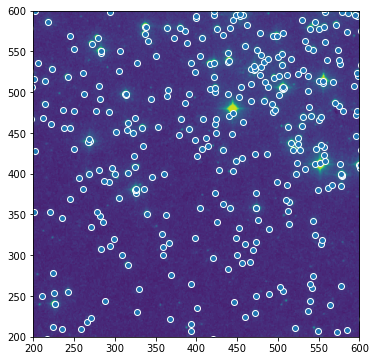

In [25]:
plt.imshow(star_image_nobkg)
plt.plot(sources["xcentroid"], sources['ycentroid'], "o", mfc=None, mec="white")
plt.xlim(200, 600)
plt.ylim(200, 600)

## Aperture photometry

Now that we have the position of sources, we can perform aperture photometry. The first step is to create an aperture object whcih contains all the positions for which we want to measure the fluxes:

In [26]:
from photutils import CircularAperture
apertures = CircularAperture(list(zip(sources["xcentroid"], sources['ycentroid'])), r=3)

For simplicity we assume apertures of constant radii (3 pixels). We can now measure the fluxes:

In [31]:
from photutils import aperture_photometry
apphot_table = aperture_photometry(star_image_nobkg, apertures)
apphot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,1026.783106933841,3.706429637361298,26754.917366834507
2,144.23637283206799,6.364969505645846,46060.12271459757
3,608.5484893616816,5.5952510991673075,53131.937040871795
4,208.67387764481904,6.864331013250369,63019.36867602412
5,992.8711834063463,6.575519924446885,27343.865540419894
6,351.65872487901765,8.521413225353895,56048.299549800664
7,683.9219795910311,9.824795897002867,178445.84921094484
8,138.02694688242593,17.55654397146486,39021.43103597361


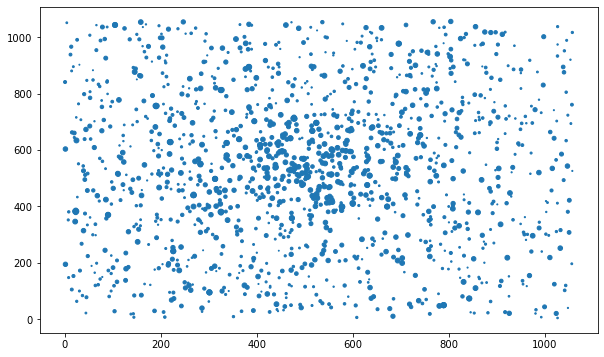

In [33]:
plt.scatter(apphot_table["xcenter"], apphot_table["ycenter"], s=apphot_table["aperture_sum"]/10000)

Note that photutils also includes functionality for PSF photometry but this is more advanced, so we do not look at it here.


<section class="challenge panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Challenge</h2>
</div>


<div class="panel-body">

<ol>
<li>Carry out aperture photometry using a radius of 5 and 10 pixels, and compare the results in a scatter plot</li>
<li>Using this, construct a table containing just the sources where the 5 and 10 pixel fluxes agree to within a factor of 2</li>
</ol>

</div>

</section>


In [42]:
import numpy as np

In [35]:
ap5 = CircularAperture(list(zip(sources["xcentroid"], sources['ycentroid'])), r=5)
ap10 = CircularAperture(list(zip(sources["xcentroid"], sources['ycentroid'])), r=10)

In [36]:
phot5_table = aperture_photometry(star_image_nobkg, ap5)
phot10_table = aperture_photometry(star_image_nobkg, ap10)

In [45]:
phot_nice = phot10_table[np.abs(phot10_table["aperture_sum"]/phot5_table["aperture_sum"]) <= 2.0]

/home/dino/miniconda3/envs/astr597/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


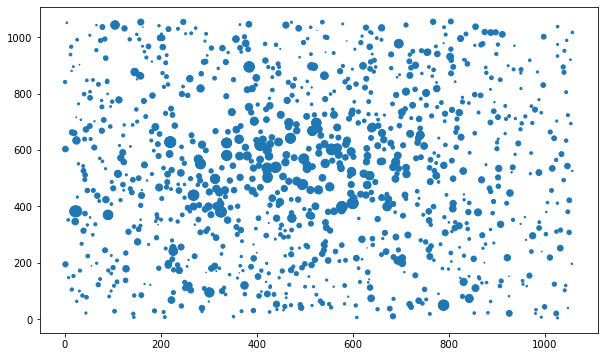

In [47]:
plt.scatter(phot_nice["xcenter"], phot_nice["ycenter"], s=phot_nice["aperture_sum"]/10000)

In [51]:
phot_nice

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,1026.783106933841,3.706429637361298,42296.23817226683
2,144.23637283206799,6.364969505645846,62140.721351511835
3,608.5484893616816,5.5952510991673075,63503.907081949685
4,208.67387764481904,6.864331013250369,82047.72939501217
5,992.8711834063463,6.575519924446885,48216.527288916215
6,351.65872487901765,8.521413225353895,60910.917664073386
7,683.9219795910311,9.824795897002867,272797.6165153808
9,760.6556049156804,18.28523456076882,90238.45782702157


<center><i>This notebook was written by <a href="https://aperiosoftware.com/">Aperio Software Ltd.</a> &copy; 2019, and is licensed under a <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License (CC BY 4.0)</a></i></center>

![cc](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by.svg)